# Ejercicio 3 — RAG (QA con documentos) — Demo Sencilla

Este ejercicio tiene un **RAG** básico con:
- *Embeddings* con **SentenceTransformers** (`all-MiniLM-L6-v2`)
- **NearestNeighbors** (scikit-learn) para búsqueda por similitud (evita problemas de FAISS en Windows)
- **pipeline** de `transformers` como *lector* (modelo SQuAD)
  
> Objetivo: poder **hacer preguntas**, **recuperar contexto** y **responder**, guardando ejemplos y una fila de resumen en `results/summary.csv` (como pide la consigna).


In [1]:
# --- Parche rápido: forzar Transformers a NO usar TensorFlow/Keras ---
import os
os.environ['TRANSFORMERS_NO_TF'] = '1'  # desactiva backend TF
os.environ['USE_TF'] = '0'              # redundante, por si acaso
# (Deja PyTorch activo por defecto)

## Instalación de librerías (ejecutar una vez por kernel)
> Usa `%pip` para instalar en **este** kernel.


In [ ]:
%pip install -qU sentence-transformers transformers datasets scikit-learn tqdm matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


## Importaciones y configuración
- Creamos carpetas de resultados si no existen.
- Verificamos si hay GPU (opcional).


In [3]:
import os, time, json, warnings, re
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from transformers import pipeline
from datasets import load_dataset

warnings.filterwarnings('ignore')

# Carpetas
os.makedirs('../results/3_rag_qa', exist_ok=True)

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")


Usando dispositivo: cpu


## Carga de datos (SQuAD pequeño)
Tomamos un **subset chico** de SQuAD para que corra rápido en cualquier PC.


In [4]:
# Cargar SQuAD v1.1 (train) y quedarnos con N ejemplos
N = 200  # cambia a 300-500 si tu PC lo permite
raw_train = load_dataset('squad')['train']

def to_row(ex):
    return {
        'title': ex['title'],
        'context': ex['context'],
        'question': ex['question'],
        'answer_text': ex['answers']['text'][0] if ex['answers']['text'] else ''
    }

small = raw_train.shuffle(seed=42).select(range(N)).map(to_row, remove_columns=raw_train.column_names)
df_small = pd.DataFrame(small)
print(df_small.head(2))
print(f"Total ejemplos (subset): {len(df_small)}")

README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

                 title                                            context  \
0                Egypt  The Pew Forum on Religion & Public Life ranks ...   
1  Ann_Arbor,_Michigan  The Ann Arbor Hands-On Museum is located in a ...   

                                            question answer_text  
0  What percentage of Egyptians polled support de...         84%  
1         Ann Arbor ranks 1st among what goods sold?       books  
Total ejemplos (subset): 200


## Indexación (embeddings + búsqueda)
- **Embeddings** con `all-MiniLM-L6-v2` (rápido y liviano).
- Índice de **NearestNeighbors** con métrica coseno.


In [5]:
# Modelo de embeddings
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Pasajes (contextos) únicos para reducir trabajo
passages = list({c for c in df_small['context'].tolist()})
print(f"Pasajes únicos: {len(passages)}")

# Embeddings de pasajes
pass_emb = embed_model.encode(passages, show_progress_bar=True, convert_to_numpy=True).astype('float32')

# Índice de vecinos cercanos (coseno)
index = NearestNeighbors(n_neighbors=5, metric='cosine').fit(pass_emb)

def retrieve(query, k=5):
    qv = embed_model.encode([query], convert_to_numpy=True).astype('float32')
    dists, idxs = index.kneighbors(qv, n_neighbors=k, return_distance=True)
    ctxs = [passages[i] for i in idxs[0]]
    return ctxs, dists[0].tolist()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Pasajes únicos: 200


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

## Modelo lector (QA)
Usamos un modelo listo para SQuAD para extraer respuesta del contexto recuperado.


In [6]:
qa = pipeline('question-answering',
               model='deepset/roberta-base-squad2',
               tokenizer='deepset/roberta-base-squad2',
               device=0 if torch.cuda.is_available() else -1)

def answer_with_rag(question, k=3):
    ctxs, _ = retrieve(question, k=k)
    best = {'answer': '', 'score': -1.0, 'context': ''}
    for ctx in ctxs:
        out = qa(question=question, context=ctx)
        if float(out['score']) > best['score']:
            best = {'answer': out['answer'], 'score': float(out['score']), 'context': ctx}
    return best


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


## Métricas (Exact Match y F1 simplificados)
Estas métricas son suficientes para el **portfolio**.


In [7]:
def _normalize(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\b(a|an|the)\b", " ", s)   # artículos
    s = re.sub(r"[^\w\s]", " ", s)          # puntuación
    s = re.sub(r"\s+", " ", s).strip()
    return s

def exact_match(pred: str, truth: str) -> int:
    return int(_normalize(pred) == _normalize(truth))

def f1_score_tokens(pred: str, truth: str) -> float:
    p = _normalize(pred).split()
    t = _normalize(truth).split()
    if len(p)==0 and len(t)==0: return 1.0
    if len(p)==0 or len(t)==0: return 0.0
    cp, ct = Counter(p), Counter(t)
    num_same = sum((cp & ct).values())
    if num_same == 0: return 0.0
    precision = num_same / len(p)
    recall = num_same / len(t)
    return 2 * precision * recall / (precision + recall)


## Evaluación y guardado de ejemplos
- Probamos **K** preguntas.
- Guardamos `results/3_rag_qa/examples.csv` con *question, pred_answer, true_answer, context_used, score, exact_match, f1*.


In [8]:
K = 50  # puedes subir a 100 o más si tu PC lo permite
sample = df_small.sample(n=min(K, len(df_small)), random_state=42)

records = []
t0 = time.time()
for _, row in tqdm(sample.iterrows(), total=len(sample)):
    q = row['question']
    truth = row['answer_text']
    best = answer_with_rag(q, k=3)
    em = exact_match(best['answer'], truth)
    f1 = f1_score_tokens(best['answer'], truth)
    records.append({
        'question': q,
        'pred_answer': best['answer'],
        'true_answer': truth,
        'context_used': best['context'][:1000],
        'score': best['score'],
        'exact_match': em,
        'f1': f1,
        'timestamp': int(time.time())
    })
t1 = time.time()

df_eval = pd.DataFrame(records)
examples_path = '../results/3_rag_qa/examples.csv'
df_eval.to_csv(examples_path, index=False, encoding='utf-8')
print(f"Guardado ejemplos en: {examples_path}")

em_mean = df_eval['exact_match'].mean()
f1_mean = df_eval['f1'].mean()
print(f"EM medio: {em_mean:.3f} | F1 medio: {f1_mean:.3f} | Tiempo: {(t1-t0):.1f}s")


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]

Guardado ejemplos en: ../results/3_rag_qa/examples.csv
EM medio: 0.720 | F1 medio: 0.871 | Tiempo: 44.2s


## Resumen para `results/summary.csv`
Agregamos una fila con métricas del RAG (**accuracy≈EM**, **F1**). En RAG no usamos *epochs/loss*.


In [9]:
summary_path = '../results/summary.csv'
summary_row = {
    'task': 'RAG-QA',
    'model_name': 'MiniLM + NearestNeighbors + roberta-base-squad2',
    'accuracy': float(df_eval['exact_match'].mean()),
    'f1': float(df_eval['f1'].mean()),
    'loss': None,
    'epochs': None,
    'params': json.dumps({'retriever': 'all-MiniLM-L6-v2', 'reader': 'roberta-base-squad2', 'k': 3}),
    'train_time_sec': None,
    'notes': 'RAG simple (SQuAD subset); ejemplos: results/3_rag_qa/examples.csv'
}

if os.path.exists(summary_path):
    df_sum = pd.read_csv(summary_path)
    df_sum = pd.concat([df_sum, pd.DataFrame([summary_row])], ignore_index=True)
else:
    df_sum = pd.DataFrame([summary_row])

df_sum.to_csv(summary_path, index=False, encoding='utf-8')
print(f"Actualizado: {summary_path}")
df_sum.tail(5)

Actualizado: ../results/summary.csv


,model_name,notebook_name,test_accuracy,f1,test_loss,epochs,model_params,training_time,final_g_loss,final_d_loss,...,final_val_accuracy,final_training_loss,final_val_loss,timestamp,task,accuracy,loss,params,train_time_sec,notes
0,fashion_mnist_cnn_baseline,1_cnn_classification,NaN,NaN,NaN,NaN,470122.0,NaN,NaN,NaN,...,0.9219,0.220919,0.212786,2025-10-05T17:56:07.985152,NaN,NaN,NaN,NaN,NaN,NaN
1,dcgan_celeba_64,2_dcgan_generation,NaN,NaN,7.941555,5.0,6342272.0,1725.872513,7.941555,0.604401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lstm_imdb_tuned,4_lstm_text_imdb,NaN,NaN,NaN,NaN,2732993.0,NaN,NaN,NaN,...,0.8736,0.227659,0.311605,2025-10-05T19:14:40.008374,NaN,NaN,NaN,NaN,NaN,NaN
3,MiniLM + NearestNeighbors + roberta-base-squad2,NaN,NaN,0.870587,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAG-QA,0.72,None,"{""retriever"": ""all-MiniLM-L6-v2"", ""reader"": ""r...",None,RAG simple (SQuAD subset); ejemplos: results/3...


## Visualización rápida (histograma de F1)
Gráfico sencillo para mostrar distribución de F1.


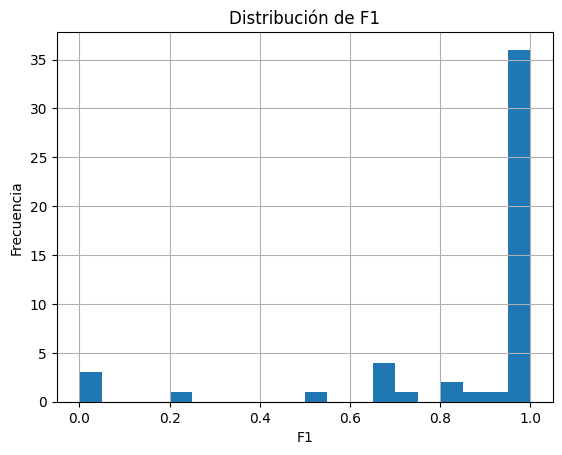

In [10]:
import matplotlib.pyplot as plt

plt.figure()
df_eval['f1'].hist(bins=20)
plt.title('Distribución de F1')
plt.xlabel('F1')
plt.ylabel('Frecuencia')
plt.show()